# IBM Data Science Professional Certificate Capstone Project

In [2]:
import pandas as pd
import numpy as np
import os
import requests
import folium
import geopy.distance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from math import cos, radians
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

#Useful links
- https://towardsdatascience.com/exploring-the-taste-of-nyc-neighborhoods-1a51394049a4
- https://developer.foursquare.com/docs/api-reference/venues/search/
- https://medium.com/@felipe.testaa/unsupervised-machine-learning-kmeans-clustering-of-s%C3%A3o-paulo-subway-stations-using-foursquare-c5101727dd85

In [3]:
df = pd.read_csv("Neighborhood_Centers_in_King_County___neighborhood_centers_point.csv")
df = df[['NAME', 'LATITUDE', 'LONGITUDE' ]]

seattle_coordinates = (47.6062, -122.3321)

# Calculate distance to city center for each neighborhood and add it as a column
distances = []
for idx, neighborhood in df.iterrows():
    neighborhood_coordinates = (neighborhood.LATITUDE, neighborhood.LONGITUDE)
    km_to_city_center = geopy.distance.distance(seattle_coordinates, neighborhood_coordinates).km
    distances.append(km_to_city_center)
df['KM_TO_CITY_CENTER'] = distances
drop_cities_farther_than = 13
df = df[df['KM_TO_CITY_CENTER'] <= drop_cities_farther_than]
df.head()

,NAME,LATITUDE,LONGITUDE,KM_TO_CITY_CENTER
1,Northgate Neighborhood,47.708593,-122.323276,11.403751
2,Lake City Neighborhood,47.719278,-122.295228,12.873825
4,Wedgewood Neighborhood,47.675783,-122.290273,8.350559
5,University District,47.661268,-122.313133,6.286332
6,Green Lake Neighborhood,47.679490,-122.325846,8.162216


In [4]:
df.head()

,NAME,LATITUDE,LONGITUDE,KM_TO_CITY_CENTER
1,Northgate Neighborhood,47.708593,-122.323276,11.403751
2,Lake City Neighborhood,47.719278,-122.295228,12.873825
4,Wedgewood Neighborhood,47.675783,-122.290273,8.350559
5,University District,47.661268,-122.313133,6.286332
6,Green Lake Neighborhood,47.679490,-122.325846,8.162216


In [5]:
seattle_map = folium.Map(location=seattle_coordinates, zoom_start=11)

for lat, lng, name in zip(df['LATITUDE'], df['LONGITUDE'], df['NAME']):
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        color='blue',
        fill=True,
        fill_opacity=1.0,
        popup=label
    ).add_to(seattle_map)
seattle_map

In [6]:
# Get venue data from foursquare

# The 2 closest neighborhoods are just over 1000m apart, using a radius half that size ensures no overlap
# also 500m feels like it would be a good size
neighborhood_radius = 500

# DELETE ME! Did I forget? Oopsie. Too lazy to tell my OS to do it on startup. I guess you can make API calls as me
os.environ['FOURSQUARE_CLIENT_ID'] = '2XE1BOCTQGJLRNMWZ52LPUL1VSR4UPJ01YHIX05QED1WN4HP'
os.environ['FOURSQUARE_CLIENT_SECRET'] = 'EW000KM3ZKVLCUFVCOEH2HRPQHLWGWAFALZVKVVRUWGETUW5'

foursquare_client_id = os.environ['FOURSQUARE_CLIENT_ID']
foursquare_client_secret = os.environ['FOURSQUARE_CLIENT_SECRET']

# auth_params = 'client_id={}&client_secret={}'.format(foursquare_client_id, foursquare_client_secret)
# version_params = 'v=20200101'
# url = 'https://api.foursquare.com/v2/venues/categories?' + auth_params + '&' + version_params
# response = requests.get(url)
# categories = response.json()['response']['categories']
# for c in categories:
#     print(c['name'])

In [7]:
relevant_categories = ['Arts & Entertainment', 'Event', 'Food']
# for c in categories:
#     print(c['name'], c['id'])
count = 0
food_venues = []
for c in categories:
    if c['name'] == 'Food':
        for cc in c['categories']:
            food_venues.append(cc['name'])
            count += 1
    
count

NameError: name 'categories' is not defined

In [ ]:
for c in categories:
    print(c['name'],':',c['id'])
category_ids = {
    'Arts & Entertainment': '4d4b7104d754a06370d81259',
    'College & University': '4d4b7105d754a06372d81259',
    'Event': '4d4b7105d754a06373d81259',
    'Food': '4d4b7105d754a06374d81259',
    'Nightlife Spot': '4d4b7105d754a06376d81259',
    'Outdoors & Recreation': '4d4b7105d754a06377d81259',
    'Professional & Other Places': '4d4b7105d754a06375d81259',
    'Residence' : '4e67e38e036454776db1fb3a',
    'Shop & Service': '4d4b7105d754a06378d81259',
    'Travel & Transport': '4d4b7105d754a06379d81259'
}


In [ ]:
def assemble_foursquare_url(base, params=[]):
    url = base + '?' + auth_params + '&' + version_params
    for param in params:
        url += '&' + str(param)
    return url

In [ ]:
def get_venues_for_neighborhood(radius, category_id, latitude, longitude):
    url_base = 'https://api.foursquare.com/v2/venues/search'
    url_params = ['limit=50', 'radius={}'.format(radius), 'categoryId={}'.format(category_id), 'll={},{}'.format(latitude, longitude)]
    url = assemble_foursquare_url(url_base, url_params)
    response = requests.get(url)
    venues = response.json()['response']['venues']
    return venues
    
def offset_latitude(original, offset):
    return original + offset / 111111

def offset_longitude(original, offset, latitude):
    return original + offset / (111111 * cos(radians(latitude)))
    
def get_venues_for_all_neighborhoods(dataframe, category):
    if category not in category_ids:
        raise Exception(category, 'is not a valid category')
    venue_df = pd.DataFrame(columns=['name', 'categories', 'TOP_LEVEL_CATEGORY', 'NEIGHBORHOOD', 'NEIGHBORHOOD_LAT', 'NEIGHBORHOOD_LNG'])
    for idx, row in dataframe.iterrows():
        radius = 250
        print('Fetching', category, 'venues for neighborhood:', row.NAME)
        venues = get_venues_for_neighborhood(radius, category_ids[category], row.LATITUDE, row.LONGITUDE)
        print(len(venues), 'venues found!')
        if len(venues) == 50:
            print("Max venues found! Subsearching...")
            offset = radius // 2
            new_points = []
            new_points.append((offset_latitude(row.LATITUDE, offset), row.LONGITUDE))
            new_points.append((offset_latitude(row.LATITUDE, -offset), row.LONGITUDE))
            new_points.append((row.LATITUDE, offset_longitude(row.LONGITUDE, offset, row.LATITUDE)))
            new_points.append((row.LATITUDE, offset_longitude(row.LONGITUDE, -offset, row.LATITUDE)))
            for pt in new_points:
                venues = get_venues_for_neighborhood(offset, category_ids[category], pt[0], pt[1])
                print("subsearch found", len(venues), "venues")
                temp_df = pd.DataFrame(venues)
                temp_df['NEIGHBORHOOD'] = row.NAME
                temp_df['NEIGHBORHOOD_LAT'] = row.LATITUDE
                temp_df['NEIGHBORHOOD_LNG'] = row.LONGITUDE
                temp_df['TOP_LEVEL_CATEGORY'] = category
                venue_df = venue_df.append(temp_df)
        else:
            temp_df = pd.DataFrame(venues)
            temp_df['NEIGHBORHOOD'] = row.NAME
            temp_df['NEIGHBORHOOD_LAT'] = row.LATITUDE
            temp_df['NEIGHBORHOOD_LNG'] = row.LONGITUDE
            temp_df['TOP_LEVEL_CATEGORY'] = category
            venue_df = venue_df.append(temp_df)
    venue_df = venue_df[['name', 'categories', 'TOP_LEVEL_CATEGORY', 'NEIGHBORHOOD', 'NEIGHBORHOOD_LAT', 'NEIGHBORHOOD_LNG']]
    venue_df['categories'] = venue_df['categories'].apply(lambda c: c[0]['name'])
    venue_df = venue_df.rename(columns={"name": "VENUE", "categories": "CATEGORY"})
    venue_df.drop_duplicates(inplace=True)
    return venue_df

In [27]:
# Use if kernel has been restarted
vdf = pd.read_csv('seattle_venues.csv')

In [ ]:
vdf = pd.DataFrame()
for category in category_ids:
    vdf = vdf.append(get_venues_for_all_neighborhoods(df, category))

In [ ]:
counts = vdf.groupby(['NEIGHBORHOOD', 'TOP_LEVEL_CATEGORY']).count()[['VENUE']]
counts.head()

In [ ]:
vdf.to_csv('seattle_venues.csv', index_label=False)

In [28]:
vdf_onehot = pd.get_dummies(vdf[['TOP_LEVEL_CATEGORY']], prefix='', prefix_sep='')
vdf_onehot['NEIGHBORHOOD'] = vdf['NEIGHBORHOOD']

ordered_columns = vdf_onehot.columns.tolist()
ordered_columns.insert(0, ordered_columns.pop(ordered_columns.index('NEIGHBORHOOD')))
vdf_onehot = vdf_onehot[ordered_columns]

venue_ratios_df = vdf_onehot.groupby('NEIGHBORHOOD').mean()


In [29]:
vdf2 = venue_ratios_df.copy()
vdf2 = vdf2[['Food', 'Nightlife Spot', 'College & University']]
vdf2.head()

,Food,Nightlife Spot,College & University
NEIGHBORHOOD,,,
Admiral Neighborhood,0.248175,0.072993,0.007299
Alki Neighborhood,0.381579,0.092105,0.000000
Ballard Neighborhood,0.198347,0.123967,0.000000
Beacon Hill Neighborhood,0.269231,0.038462,0.000000
Capitol Hill Neighborhood,0.223005,0.115023,0.112676


In [9]:
# count of food, nightlife, and college
vdf_sum1 = vdf_onehot[['NEIGHBORHOOD', 'Food', 'College & University', 'Nightlife Spot']].groupby('NEIGHBORHOOD').sum()

sil = []
K_sil = range(2,8)
for k in K_sil:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(vdf_sum1)
    labels = kmeans.labels_
    sil.append(silhouette_score(vdf_sum1, labels, metric = 'euclidean'))
plt.plot(K_sil, sil, 'bo-')
plt.xticks(K_sil)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show

k = 6
kmeans = KMeans(k).fit(vdf_sum1)
vdf_sum1['LABEL'] = kmeans.labels_
vdf_sum1.sort_values(by=['LABEL'])

NameError: name 'vdf_onehot' is not defined

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,LABEL
NEIGHBORHOOD,,,,,,,,,,
Admiral Neighborhood,7,1,34,10,11,16,9,44,5,0
Wallingford Neighborhood,4,0,44,10,7,26,6,45,11,0
Northgate Neighborhood,5,1,22,2,10,39,8,45,17,0
West Seattle Neighborhood,11,1,45,17,15,34,14,45,16,0
Lake City Neighborhood,4,1,37,8,8,34,11,36,10,0
Greenwood Neighborhood,20,2,45,15,8,38,5,48,13,0
Georgetown Neighborhood,18,0,26,13,4,22,0,44,5,0
Magnolia Neighborhood,3,0,23,7,13,32,3,41,4,0
White Center Neighborhood,2,0,42,18,5,18,0,43,4,0


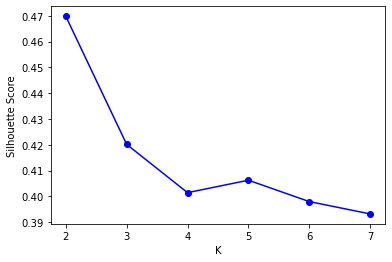

In [30]:
# normalized count of everything BEST
vdf_sum2 = vdf_onehot.groupby('NEIGHBORHOOD').sum()

rand = 3
scaled = StandardScaler().fit_transform(np.asarray(vdf_sum2))
sil = []
errors = []
K = range(2,8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=rand).fit(scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(scaled, labels, metric = 'euclidean'))
    errors.append(kmeans.inertia_)
plt.plot(K, sil, 'bo-')
plt.xticks(K)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show

k = 5
kmeans = KMeans(k, random_state=rand).fit(scaled)
vdf_sum2['LABEL'] = kmeans.labels_
vdf_sum2.sort_values(by=['LABEL'])

In [11]:
# food ratio only 
vdff = venue_ratios_df.copy()
vdff = vdff[['Food']]

K = range(1, 20)
errors = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vdff)
    errors.append(kmeans.inertia_)
plt.plot(K, errors, 'bo-')
plt.xticks(K)
plt.show()

k = 5
kmeans = KMeans(k).fit(vdff)
kmeans.labels_
lst = []
for n, l, s, f in zip(vdff.index.values.tolist(), kmeans.labels_, vdf_sum['Food'].values.tolist(), vdff['Food'].values.tolist()):
    lst.append([n, l, s, f])
sorted(lst, key=lambda x: x[3])

NameError: name 'venue_ratios_df' is not defined

In [12]:
vdf_sum = vdf_onehot.groupby('NEIGHBORHOOD').sum()
vdf_sum.head()

NameError: name 'vdf_onehot' is not defined

In [13]:

a = np.asarray(vdf_sum)
vdf_ss = StandardScaler().fit_transform(a)
vdf_ss.shape


NameError: name 'vdf_sum' is not defined

In [14]:
K = range(1, 10)
errors = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vdf_ss)
    errors.append(kmeans.inertia_)
plt.plot(K, errors, 'bo-')
plt.xticks(K)
plt.show()

NameError: name 'vdf_ss' is not defined

In [15]:


sil = []
K_sil = range(2,20)
for k in K_sil:
    kmeans = KMeans(n_clusters=k).fit(vdf2)
    labels = kmeans.labels_
    sil.append(silhouette_score(vdf2, labels, metric = 'euclidean'))
plt.plot(K_sil, sil, 'bo-')
plt.xticks(K_sil)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show

NameError: name 'vdf2' is not defined

In [16]:
k = 5
kmeans = KMeans(k).fit(vdf2)
kmeans.labels_
for n, l in zip(vdf2.index.values.tolist(), kmeans.labels_):
    print(n, l)

NameError: name 'vdf2' is not defined

In [17]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,20)
for k in K_sil:
    kmeans = KMeans(n_clusters=k).fit(vdf_ss)
    labels = kmeans.labels_
    sil.append(silhouette_score(vdf_ss, labels, metric = 'euclidean'))
plt.plot(K_sil, sil, 'bo-')
plt.xticks(K_sil)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show

NameError: name 'vdf_ss' is not defined

### KMeans analysis of food venues
Scrapped this because it didn't provide a very good result

In [18]:
vdf_onehot = pd.get_dummies(vdf[['CATEGORY']], prefix='', prefix_sep='')
vdf_onehot['NEIGHBORHOOD'] = vdf['NEIGHBORHOOD']

ordered_columns = vdf_onehot.columns.tolist()
ordered_columns.insert(0, ordered_columns.pop(ordered_columns.index('NEIGHBORHOOD')))
vdf_onehot = vdf_onehot[ordered_columns]

vdf_grouped = vdf_onehot.groupby('NEIGHBORHOOD').mean().reset_index()

seattle_clustering = vdf_grouped.drop('NEIGHBORHOOD', axis=1)

NameError: name 'vdf' is not defined

In [19]:
cat_counts = vdf[['CATEGORY', 'NEIGHBORHOOD']].groupby('NEIGHBORHOOD').count().sort_values(by=['CATEGORY'], ascending=False).reset_index()


NameError: name 'vdf' is not defined

In [20]:
kmax = 20
errors = []
for k in range(1,kmax):
    kmeans = KMeans(n_clusters=k, random_state=2)
    kmeans.fit(seattle_clustering)
    errors.append(kmeans.inertia_)
plt.plot(range(1,kmax), errors, 'bo-')

NameError: name 'seattle_clustering' is not defined

In [21]:
# Explanations for bad elbow: https://stats.stackexchange.com/questions/89679/what-do-you-do-when-theres-no-elbow-point-for-kmeans-clustering

In [22]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(seattle_clustering)

NameError: name 'seattle_clustering' is not defined

In [23]:
cat_counts['LABEL'] = kmeans.labels_
cat_counts

AttributeError: 'KMeans' object has no attribute 'labels_'

In [32]:
df_labeled = df.merge(vdf_sum2[['LABEL']], left_on='NAME', right_on='NEIGHBORHOOD')
# df_labeled.drop('LABEL_x', axis=1, inplace=True)
df_labeled.rename({'LABEL_y': 'LABEL'}, axis=1, inplace=True)
df_labeled.sort_values(by=['LABEL'], inplace=True)
df_labeled.reset_index(drop=True, inplace=True)
df_labeled


,NAME,LATITUDE,LONGITUDE,KM_TO_CITY_CENTER,LABEL
0,Northgate Neighborhood,47.708593,-122.323276,11.403751,0
1,Admiral Neighborhood,47.581194,-122.386548,4.949615,0
2,Columbia City Neighborhood,47.557847,-122.285044,6.436788,0
3,Georgetown Neighborhood,47.547926,-122.316094,6.589935,0
4,Magnolia Neighborhood,47.639553,-122.401007,6.370171,0
5,White Center Neighborhood,47.517352,-122.354020,10.015085,0
6,Central District,47.619169,-122.302550,2.648545,0
7,Wallingford Neighborhood,47.661386,-122.333720,6.136922,0
8,West Seattle Neighborhood,47.561105,-122.386779,6.485012,0
9,Lake City Neighborhood,47.719278,-122.295228,12.873825,0


In [33]:
seattle_map_labeled = folium.Map(location=seattle_coordinates, zoom_start=11)

palette = {
    0: 'darkorange',
    1: 'green',
    2: 'blue',
    3: 'darkred',
    4: 'purple',
}

for lat, lng, name, label in zip(df_labeled['LATITUDE'], df_labeled['LONGITUDE'], df_labeled['NAME'], df_labeled['LABEL']):
    popup_text = '{}\nLabel: {}'.format(name, label)
    _popup = folium.Popup(popup_text, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        color=palette[label],
        fill=True,
        fill_opacity=1.0,
        popup=_popup
    ).add_to(seattle_map_labeled)
seattle_map_labeled

### DBSCAN instead of KMeans
Produced an even poorer result

In [26]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.15).fit(seattle_clustering)
dbscan.labels_


NameError: name 'seattle_clustering' is not defined